# Migration Timeseries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from palettable.cubehelix import Cubehelix
import seaborn as sns
import math

In [2]:
OUTPUT_DIR="migration_timeseries/"
CYCLES_PER_SEC = 250000000
CYCLE_TIME = 4 * (10**-9)

In [3]:
1/(4 * (10 ** -9))

249999999.99999997

In [4]:
def save_fig(file_name, figure, output_dir):
    figure.patch.set_facecolor("white")
    figure.savefig(output_dir + file_name, bbox_inches="tight")

In [5]:
def trim_series(input_df, trim_end_cycles):
    input_df["timestamp"] = input_df["timestamp"].apply(int, base=16)
    input_df["reqs_done"] = input_df["reqs_done"].apply(int, base=16)
    trimmed_data = input_df.loc[input_df["reqs_done"] != 0]

    last_time = trimmed_data.iloc[-1]["timestamp"]
    
    last_trim_time = last_time - trim_end_cycles
    trimmed_data = trimmed_data.loc[trimmed_data["timestamp"] < last_trim_time]

    start_time = trimmed_data.iloc[0]["timestamp"]
    trimmed_data["adjusted_time"] = trimmed_data["timestamp"] - start_time
    return trimmed_data

In [6]:
timeseries_data = pd.read_csv("test_file.csv")
trimmed_data = trim_series(timeseries_data, CYCLES_PER_SEC/2)


In [7]:
taskset_timeseries_data = pd.read_csv("taskset_test_file.csv")
trimmed_taskset = trim_series(taskset_timeseries_data, 0)

In [36]:
open_loop = pd.read_csv("open_loop_test_file.csv")
open_loop_trimmed = trim_series(open_loop, CYCLES_PER_SEC/4).sort_values("adjusted_time")
open_loop_trimmed


KeyError: 'timestamp'

In [ ]:
open_loop_trimmed = open_loop_trimmed.drop_duplicates()
open_loop_trimmed = open_loop_trimmed[0:19000]

In [37]:
req_log = pd.read_csv("req_log_test_file.csv")
req_log_trimmed = trim_series(req_log, 0).sort_values("adjusted_time")

In [38]:
big_req_log = pd.read_csv("req_log_test_file_10000.csv")
big_req_log_trimmed = trim_series(big_req_log, 0).sort_values("adjusted_time")

In [39]:
int(big_req_log_trimmed[big_req_log_trimmed["reqs_done"] == 10001]["adjusted_time"])-int(big_req_log_trimmed[big_req_log_trimmed["reqs_done"] == 10000]["adjusted_time"])

/tmp/ipykernel_3293870/4154408532.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(big_req_log_trimmed[big_req_log_trimmed["reqs_done"] == 10001]["adjusted_time"])-int(big_req_log_trimmed[big_req_log_trimmed["reqs_done"] == 10000]["adjusted_time"])


111746

In [40]:
132556/CYCLES_PER_SEC

0.000530224

In [41]:
big_req_log_trimmed[big_req_log_trimmed["reqs_done"] == 500]

,timestamp,reqs_done,adjusted_time
243,7802058649,500,11183375


In [42]:
first_client = req_log_trimmed[20:743]


In [43]:
def calc_gaps(input_dataframe):
    gaps = []
    for i in range(1, len(input_dataframe)):
        gap  = input_dataframe.iloc[i]["adjusted_time"] - input_dataframe.iloc[i-1]["adjusted_time"]
        gaps.append(gap)
    return gaps

In [44]:
first_client = big_req_log_trimmed[200:10000]

In [45]:
gaps = calc_gaps(first_client)

In [46]:
mean = np.mean(gaps)
std_dev = np.std(gaps)
print(mean, std_dev)

22241.131339932646 1508.7679402130018


In [47]:
25000/CYCLES_PER_SEC

0.0001

<Axes: xlabel='adjusted_time'>

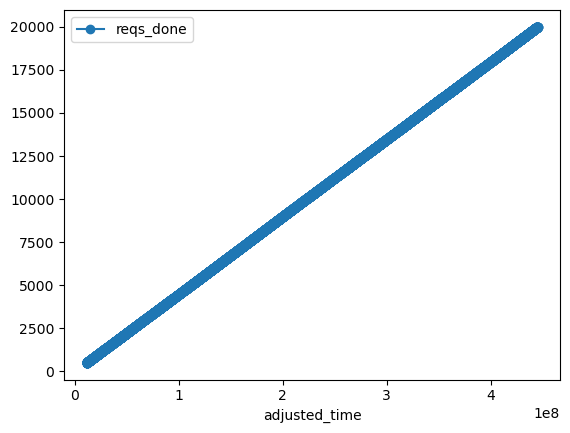

In [48]:
big_req_log_trimmed[243:].plot(x="adjusted_time", y="reqs_done", marker="o")

In [49]:
period_seconds = 49999/CYCLES_PER_SEC

In [50]:
101/period_seconds

505010.100202004

In [51]:
def collect_intervals(input_dataframe, interval_cycles):
    intervals = []
    next_timestamp = input_dataframe.iloc[0]["adjusted_time"] + interval_cycles
    interval_start_reqs = input_dataframe.iloc[0]["reqs_done"]
    start_timestamp = input_dataframe.iloc[0]["adjusted_time"]
    i = 0
    migration_happened = False
    for index, row in input_dataframe.iterrows():
        if row["adjusted_time"] >= next_timestamp or ((not migration_happened) and (row["reqs_done"] == 1000)):
            if (row["reqs_done"] == 1000):
                migration_happened = True
            adjusted_time = row["adjusted_time"]
            reqs_done = row["reqs_done"] - interval_start_reqs
            period_cycles = row["adjusted_time"] - start_timestamp
            period_seconds = period_cycles/CYCLES_PER_SEC
            reqs_per_sec = reqs_done/period_seconds
            #if (period_cycles != interval_cycles):
            #    print(i, period_cycles, reqs_per_sec)
            new_entry = {"time": row["adjusted_time"]/CYCLES_PER_SEC, "reqs_per_sec": reqs_per_sec}
            intervals.append(new_entry)

            start_timestamp = row["adjusted_time"]
            interval_start_reqs = row["reqs_done"]
            next_timestamp = row["adjusted_time"] + interval_cycles
        i += 1
    return pd.DataFrame(intervals)

In [52]:
900/CYCLES_PER_SEC

3.6e-06

In [53]:
def collect_req_log_intervals_fixed(input_dataframe, interval_cycles):
    intervals = []
    start_time = input_dataframe.iloc[0]["adjusted_time"] - 300
    process_df = input_dataframe
    end_time = process_df.iloc[-1]["adjusted_time"]
    period_seconds = interval_cycles/CYCLES_PER_SEC
    start_time = 0

    while (start_time <= end_time):
        # find all the entries between the start and the end of the interval
        reqs = process_df.loc[process_df.adjusted_time.ge(start_time) & process_df.adjusted_time.le(start_time + interval_cycles)]

        if len(reqs) != 0:
            # minus one, because probably the period starts before the first thing
            start_reqs = reqs.iloc[0]["reqs_done"]-1
            end_reqs = reqs.iloc[-1]["reqs_done"]
            reqs_period = end_reqs - start_reqs
            reqs_per_sec = reqs_period/period_seconds
            new_entry = {"time": (start_time + interval_cycles)/CYCLES_PER_SEC, "reqs_per_sec": reqs_per_sec, "num_reqs": reqs_period}
            intervals.append(new_entry)
        else:
            new_entry = {"time": (start_time + interval_cycles)/CYCLES_PER_SEC, "reqs_per_sec": 0, "num_reqs": 0}
            intervals.append(new_entry)

        start_time = start_time + interval_cycles
    return pd.DataFrame(intervals)


In [54]:
def collect_req_log_intervals_variable(input_dataframe):
    intervals = []
    for i in range(1, len(input_dataframe)-1):
        next_row = input_dataframe.iloc[i+1]
        prev_row = input_dataframe.iloc[i-1]
        curr_row = input_dataframe.iloc[i]
        reqs_period = next_row["reqs_done"] - prev_row["reqs_done"]
        period_cycles = next_row["adjusted_time"] - prev_row["adjusted_time"]
        period_seconds = period_cycles/CYCLES_PER_SEC

        reqs_per_sec = reqs_period/period_seconds
        new_entry = {"time": curr_row["adjusted_time"]/CYCLES_PER_SEC, "reqs_per_sec": reqs_per_sec}
        intervals.append(new_entry)
    return pd.DataFrame(intervals) 

In [55]:
def collect_req_log_intervals_avg(input_dataframe):
    intervals = []
    for i in range(1, len(input_dataframe)):
        prev_row = input_dataframe.iloc[i-1]
        curr_row = input_dataframe.iloc[i]
        reqs_period = curr_row["reqs_done"] - prev_row["reqs_done"]
        period_cycles = curr_row["adjusted_time"] - prev_row["adjusted_time"]
        period_seconds = period_cycles/CYCLES_PER_SEC
        reqs_per_sec = reqs_period/period_seconds

        record_time = prev_row["adjusted_time"] + (period_cycles/2)
        new_entry = {"time": record_time/CYCLES_PER_SEC, "reqs_per_sec": reqs_per_sec}
        intervals.append(new_entry)
    return pd.DataFrame(intervals)

In [56]:
def adjust_time(input_dataframe):
    start = input_dataframe.iloc[0]["time"]

    adjusted = input_dataframe.assign(time=lambda row: row["time"]-start)
    return adjusted

In [57]:
len(req_log_trimmed.loc[req_log_trimmed.adjusted_time.ge(90000) & req_log_trimmed.adjusted_time.le(105000)])

1

In [58]:
interval_df = collect_intervals(trimmed_data, 75000)
trimmed_data.iloc[745]

timestamp        7753577499
reqs_done               115
adjusted_time       3782500
Name: 759138, dtype: int64

In [59]:
open_interval_df = collect_req_log_intervals_fixed(open_loop_trimmed, 49999)
open_interval_df[200:300]

NameError: name 'open_loop_trimmed' is not defined

In [ ]:
req_interval_df = collect_req_log_intervals_fixed(req_log_trimmed, 24999)
req_interval_df[600:800]

In [ ]:
big_req_interval_df = collect_req_log_intervals_variable(big_req_log_trimmed[243:])

In [ ]:
req_interval_df.loc[req_interval_df["num_reqs"] == 2]

In [ ]:
req_log_trimmed.iloc[20]

In [60]:
req_interval_der = collect_req_log_intervals_variable(req_log_trimmed)

In [61]:
req_interval_der_2 = collect_req_log_intervals_variable(req_log_trimmed)

In [62]:
def plot_timeseries(input_df, reqs_field):
    fig, ax = plt.subplots()
    input_df.plot(x="time", y=reqs_field, ax=ax)

    y_max = input_df[reqs_field].max() * 1.10
    x_max = input_df.iloc[-1]["time"]
    
    ax.set_ylim(0, y_max)
    ax.set_xlim(0, x_max)

    ax.set_xlabel("Time (s)", fontsize=16)
    ax.set_ylabel("Throughput (ops/sec)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.draw()

    return fig, ax

In [65]:
plot_timeseries(taskset_intervals[200:1000], "reqs_per_sec")

NameError: name 'taskset_intervals' is not defined

In [66]:
#req_interval_df = req_interval_df.assign(avg_reqs_per_sec=req_interval_df["reqs_per_sec"].rolling(1, center=True).mean())
adjusted = adjust_time(req_interval_df[400:1800])
adjusted_avg = adjusted.assign(avg_reqs_per_sec=adjusted["reqs_per_sec"].rolling(3, center=True).mean())
plot_timeseries(adjusted_avg, "reqs_per_sec")


NameError: name 'req_interval_df' is not defined

In [67]:
req_interval_der.iloc[50]

time                0.038290
reqs_per_sec    10239.606799
Name: 50, dtype: float64

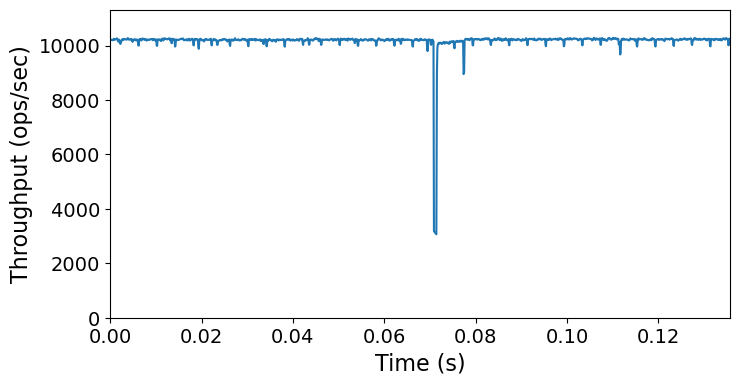

In [73]:
adjusted_der = adjust_time(req_interval_der[20:1400])
tmp_fig, tmp_ax = plot_timeseries(adjusted_der, "reqs_per_sec")
legend = tmp_ax.legend()
legend.remove()
tmp_fig.set_size_inches(8, 4)
save_fig("migration_timeseries.pdf", tmp_fig, OUTPUT_DIR)

In [69]:
tmp_fig, tmp_ax = plot_timeseries(big_req_interval_df, "reqs_per_sec")

NameError: name 'big_req_interval_df' is not defined

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time (s)', ylabel='Throughput (ops/sec)'>)

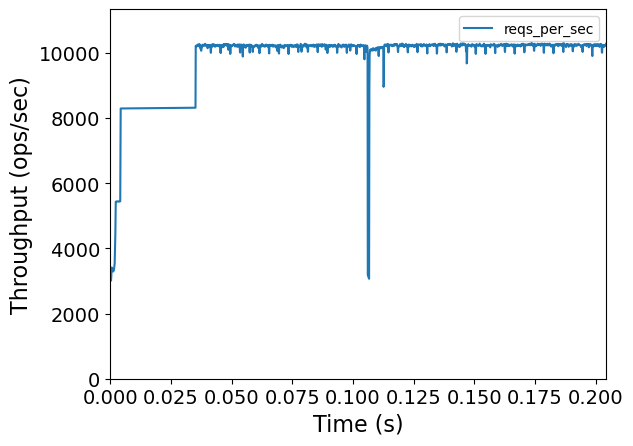

In [70]:
plot_timeseries(req_interval_der_2, "reqs_per_sec")

In [31]:
plot_timeseries(open_interval_df, "reqs_per_sec")
print(open_interval_df[100:800].loc[open_interval_df[100:800]["reqs_per_sec"] == 0])

NameError: name 'plot_timeseries' is not defined

In [32]:
plot_df = interval_df[100:500]
start_time = plot_df.iloc[0]["time"]

plot_df = plot_df.assign(time=lambda row: row["time"] - start_time)
print(plot_df.loc[plot_df["reqs_per_sec"] == 0])

tmp_fig, tmp_ax = plot_timeseries(plot_df, "reqs_per_sec")
save_fig("migration_timeseries.pdf", tmp_fig, OUTPUT_DIR)


        time  reqs_per_sec
172  0.04349           0.0
173  0.04379           0.0
342  0.14291           0.0
343  0.14321           0.0
344  0.14351           0.0
..       ...           ...
495  0.23535           0.0
496  0.23565           0.0
497  0.23595           0.0
498  0.23625           0.0
499  0.23655           0.0

[160 rows x 2 columns]


NameError: name 'plot_timeseries' is not defined

In [33]:

plotted = interval_df[100:500]
plotted = plotted.assign(avg_reqs_per_sec=plotted["reqs_per_sec"].rolling(3, center=True).mean())

In [34]:
avg_plotted = plotted[2:-2]
start_time = avg_plotted.iloc[0]["time"]
avg_time_adjust = avg_plotted.assign(time=lambda row: row["time"] - start_time)
tmp_fig, tmp_ax = plot_timeseries(avg_time_adjust, "avg_reqs_per_sec")
save_fig("migration_timeseries.pdf", tmp_fig, OUTPUT_DIR)

NameError: name 'plot_timeseries' is not defined

In [35]:
avg_plotted

,time,reqs_per_sec,avg_reqs_per_sec
102,0.05957,10000.000000,10094.562648
103,0.06239,10283.687943,10094.562648
104,0.06269,10000.000000,10094.562648
105,0.06299,10000.000000,10000.000000
106,0.06329,10000.000000,10000.000000
...,...,...,...
493,0.29121,0.000000,0.000000
494,0.29151,0.000000,0.000000
495,0.29432,0.000000,0.000000
496,0.29462,0.000000,0.000000
